#**1.IMPORT THƯ VIỆN**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, ttest_ind
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#**2.HIỂU RÕ DỮ LIỆU**

In [2]:
#Import tập dữ liệu
data = pd.read_csv('/content/seattle-weather.csv')
#Hiển thị 5 hàng đầu của tập dữ liệu
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
#In ra kích thước của tập dữ liệu
print(data.shape)

(1461, 6)


In [4]:
#Thông tin của tập dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


*Nhìn sơ qua thì ta thấy được trong tập dữ liệu này không chứa các dữ liệu NaN*

Như vậy tập dữ liệu này gồm 6 variables tương ứng với 6 cột trong tập dữ liệu:


* date: Ngày tháng năm thu được các số liệu đo lường theo định dạng YYYY-MM-DD
* precipitation: lượng mưa
* temp_max: nhiệt độ cao nhất trong ngày
* temp_min: nhiệt độ thấp nhất trong ngày
* wind: sức gió
* weather: thời tiết trong ngày



##Trực quan hóa dữ liệu

In [5]:
from sklearn.preprocessing import LabelEncoder

# Tạo label encoder
le = LabelEncoder()

# Huấn luyện encoder trên cột 'weather' và biến đổi câc giá trị thành số
data['weather_encoded'] = le.fit_transform(data['weather'])

# Tạo dictionary ánh xạ từ tên thời tiết sang giá trị đã mã hóa
weather_names = dict(zip(le.classes_, le.transform(le.classes_)))

/tmp/ipython-input-6-1079202752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weather_encoded', data=data, palette='hls')


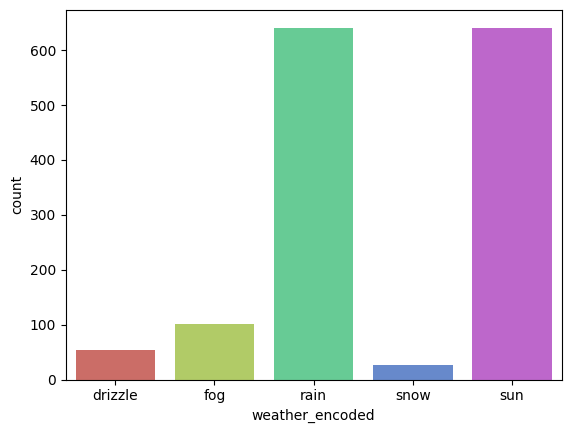

In [6]:
# Vẽ biểu đồ đếm cho từng giá trị trong cột 'weather_encoded' với nhãn là tên thời tiết thật
sns.countplot(x='weather_encoded', data=data, palette='hls')
plt.xticks(list(weather_names.values()), list(weather_names.keys()))
plt.show()

In [7]:
# Đếm số lượng cho từng nhãn thời tiết
weather_counts = data['weather'].value_counts()

# In ra số lượng từng nhãn thời tiết theo tỉ lệ với tổng số lượng
for weather, count in weather_counts.items():
    percent = (count / len(data)) * 100
    print(f"Percent of {weather.capitalize()}: {percent:.2f}%")

Percent of Rain: 43.87%
Percent of Sun: 43.81%
Percent of Fog: 6.91%
Percent of Drizzle: 3.63%
Percent of Snow: 1.78%


* Nhìn qua về biểu đồ và phần trăm từng nhãn thời tiết đã có, ta thấy Nắng và Mưa chiếm nhiều nhất, hơn 43.80%, số lượng cũng chiếm hơn 600 trong tập dữ liệu, còn về những thời tiết còn lại như Sương mù, Mưa phùn, Tuyết thì chỉ chiếm hơn 10%.
* Như vậy có thể nói dữ liệu có cho 3 thời tiết còn lại rất là ít, có thể ảnh hưởng đến quá trình và kết quả học của mô hình, dễ gây ra những dự đoán sai do thiếu dữ liệu học với những nhãn đó.

In [8]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


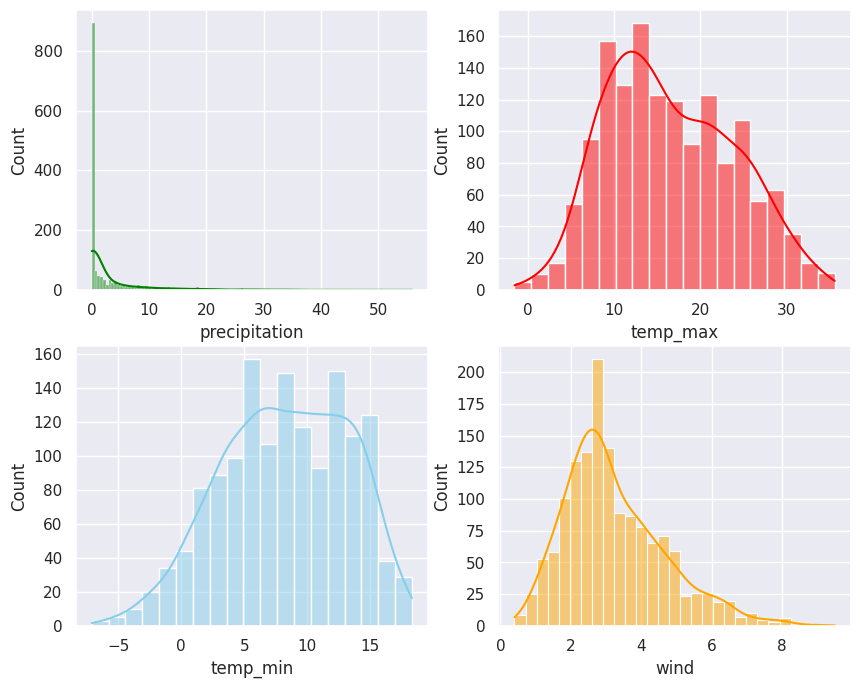

In [9]:
sns.set(style="darkgrid")

# Vẽ biểu đồ histogram với những thông số đo lường và tô màu riêng cho từng đặc trưng đó
variables = ["precipitation", "temp_max", "temp_min", "wind"]
colors = ["green", "red", "skyblue", "orange"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, var in enumerate(variables):
    sns.histplot(data=data, x=var, kde=True, ax=axs[i//2, i%2], color=colors[i])

* Nhìn qua về biểu đồ ta thấy các thông số như temp_max, precipitation và wind đều có xu hướng nghiêng về bên trái, còn temp_min thì ngược lại
* Và dựa trên đường cong KDE (đường cong mật độ) ta có thể thấy được những biến trên đều chứa một số outliers

###Sử dụng BOXPLOT để tìm giá trị ngoại lai và độ phân tán của các giá trị điều kiện

/tmp/ipython-input-10-3598991107.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="precipitation", y="weather", data=data, palette="winter", ax=ax)


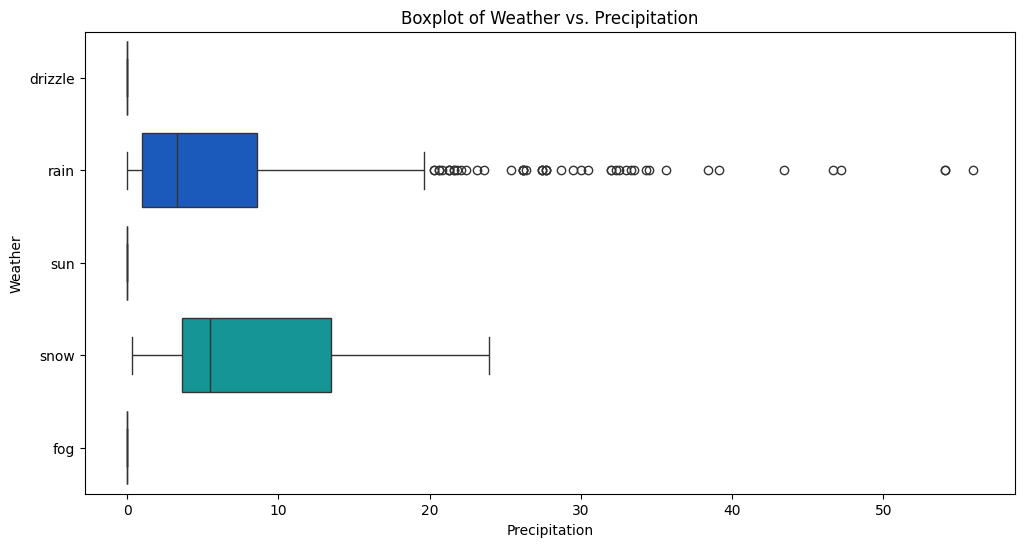

In [10]:
#BOXPLOT của weather và precipitation
with plt.style.context('default'):

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="precipitation", y="weather", data=data, palette="winter", ax=ax)
    ax.set(xlabel='Precipitation', ylabel='Weather', title='Boxplot of Weather vs. Precipitation')

Dựa trên biểu đồ ta vừa thu được, ta thấy giá trị của điều kiện mưa có nhiều ngoại lai dương, và cả hai điều kiện mưa và tuyết đều có phân phối nghiêng phải

/tmp/ipython-input-11-260375390.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="temp_max", y="weather", data=data, palette="spring", ax=ax)


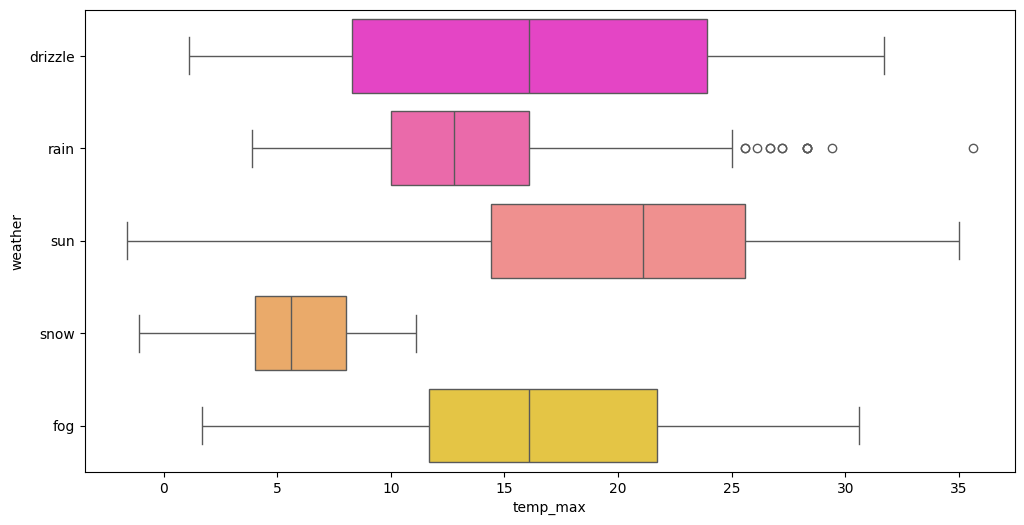

In [11]:
#BOXPLOT của weather và temp_max
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="temp_max", y="weather", data=data, palette="spring", ax=ax)

Từ biểu đồ thu được, ta thấy điều kiện mưa có nhiều ngoại lai dương và phân bố có một chút lệch phải

/tmp/ipython-input-12-1987279398.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="wind", y="weather", data=data, palette="summer", ax=ax)


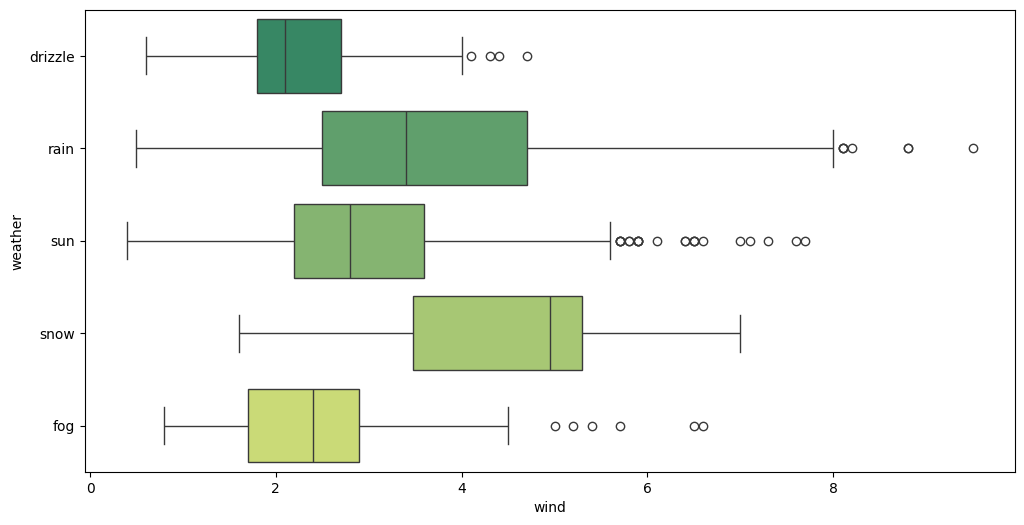

In [12]:
#BOXPLOT của weather và wind
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="wind", y="weather", data=data, palette="summer", ax=ax)

Dựa trên biểu đô trên, ta thấy rằng các điều kiện thời tiết đều có ngoại lai dương, và phân phối của tuyết và sương mù lệch trái

/tmp/ipython-input-13-4018481822.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="temp_min", y="weather", data=data, palette="autumn", ax=ax)


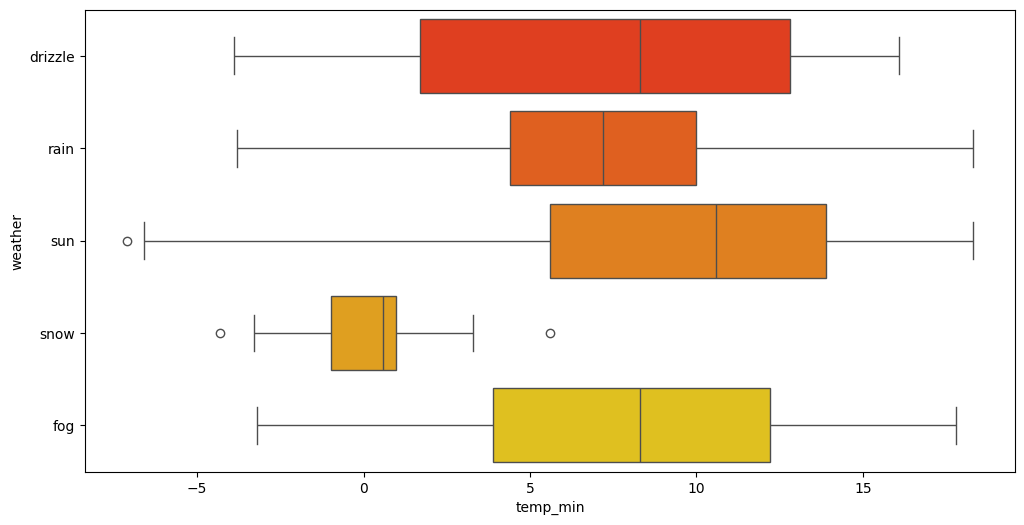

In [13]:
#BOXPLOT của weather và temp_min
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="temp_min", y="weather", data=data, palette="autumn", ax=ax)

Từ biểu đồ thu được, ta thấy rằng điều kiện thời tiết nắng có các giá trị ngoại lai âm, trong khi tuyết có cả ngoại lai âm và dương, và phân phối của tuyết bị lệch trái

###Sử dụng Scatter biểu thị độ tương quan giữa các đặc trưng

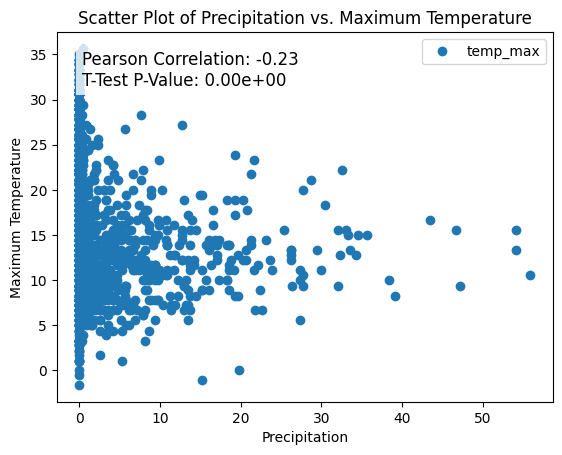

In [14]:
# Tính hệ số tương quan Pearson và giá trị p của kiểm định t giữa hai biến precipitation và temp_max
corr = data["precipitation"].corr(data["temp_max"])
ttest, pvalue = stats.ttest_ind(data["precipitation"], data["temp_max"])

# Sử dụng context manager để áp dụng kiểu hiển thị mặc định cho biểu đồ
with plt.style.context('default'):

    # Tạo biểu đồ scatter giữa hai biến precipitation và temp_max
    ax = data.plot("precipitation", "temp_max", style='o')

    # Thêm tiêu đề cho biểu đồ
    ax.set_title('Scatter Plot of Precipitation vs. Maximum Temperature')

    # Thêm nhãn cho trục hoành (x) và trục tung (y)
    ax.set_xlabel('Precipitation')  # Lượng mưa
    ax.set_ylabel('Maximum Temperature')  # Nhiệt độ tối đa

    # Thêm hộp văn bản vào biểu đồ chứa hệ số tương quan Pearson và giá trị p của kiểm định t
    textstr = f'Pearson Correlation: {corr:.2f}\nT-Test P-Value: {pvalue:.2e}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

Ta có giá trị p biểu thị độ tương quan giữa hai đặc trưng:
* -1: tương quan âm, quan hệ tuyến tính đối nghịch, đặc trưng này tăng thì đặc trưng khác giảm và ngược lại
* 1: tương quan dương, quan hệ tuyến tính đồng thuận, đặc trưng này tăng thì đặc trưng khác tăng và ngược lại
* 0: không có tương quan, không có quan hệ tuyến tính

Như vậy giữa hai đặc trưng Precipitation và temp_max thì có độ tương quan âm nhưng rất thấp, hầu như không có quan hệ tuyến tính

[Text(0.5, 1.0, 'Scatter plot of Wind vs. Maximum Temperature')]

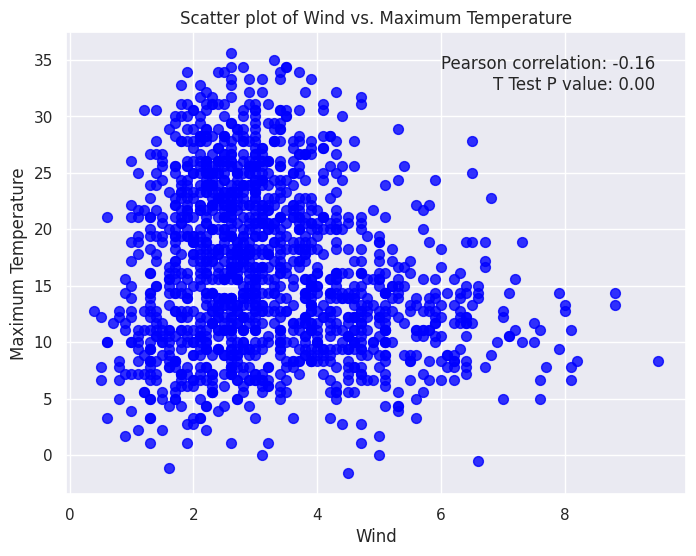

In [15]:
# Tạo biểu đồ scatter với ký hiệu và màu sắc tùy chỉnh, đồng thời chỉ định đối tượng trục (axis) một cách rõ ràng
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=data["wind"], y=data["temp_max"], marker='o', s=50, alpha=0.8, color='blue')

# Tính hệ số tương quan Pearson và giá trị p từ kiểm định t
corr = np.corrcoef(data["wind"], data["temp_max"])[0, 1]
ttest_result = stats.ttest_ind(data["wind"], data["temp_max"])
p_value = ttest_result.pvalue

# Hiển thị hệ số tương quan và giá trị p lên biểu đồ
ax.text(0.95, 0.95, f"Pearson correlation: {corr:.2f}\nT Test P value: {p_value:.2f}",
        transform=ax.transAxes, ha='right', va='top', fontsize=12)

# Thêm nhãn cho trục hoành (trục x) và trục tung (trục y)
ax.set(xlabel='Wind', ylabel='Maximum Temperature')

# Thêm tiêu đề cho biểu đồ
ax.set(title='Scatter plot of Wind vs. Maximum Temperature')

Tiếp tục thì độ tương quan giữa Wind và temp_max cũng gần bằng 0, có thể coi là không có quan hệ tuyến tính

[Text(0.5, 1.0, 'Scatter plot of Maximum vs. Minimum Temperature')]

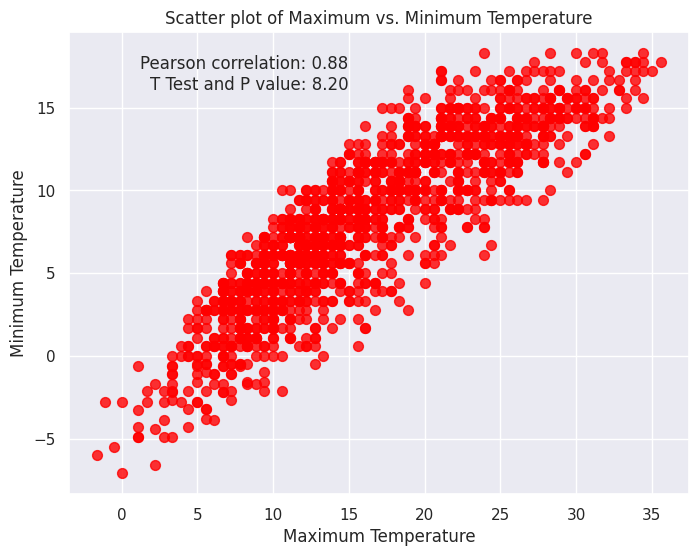

In [16]:
# Tạo biểu đồ scatter với ký hiệu và màu sắc tùy chỉnh, và chỉ định rõ đối tượng trục (axis)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=data["temp_max"], y=data["temp_min"], marker='o', s=50, alpha=0.8, color='red')

# Tính hệ số tương quan Pearson và giá trị p (ở đây là sai số trung bình giữa nhiệt độ max và min)
corr, p_value = np.corrcoef(data["temp_max"], data["temp_min"])[0, 1], np.mean(np.abs(np.subtract(data["temp_max"], data["temp_min"])))

# Hiển thị hệ số tương quan và giá trị p lên biểu đồ
ax.text(0.45, 0.95, f"Pearson correlation: {corr:.2f}\nT Test and P value: {p_value:.2f}",
        transform=ax.transAxes, ha='right', va='top', fontsize=12)

# Thêm nhãn cho trục hoành (trục x) và trục tung (trục y)
ax.set(xlabel='Maximum Temperature', ylabel='Minimum Temperature')

# Thêm tiêu đề cho biểu đồ
ax.set(title='Scatter plot of Maximum vs. Minimum Temperature')

Đây là biểu đồ biểu thị độ tương quan giữa nhiệt độ cao nhất và thấp nhất trong ngày sử dụng sai số tuyệt đối trung bình, ta thu được độ tương quan dương mạnh, gần bằng 1, tức là hầu như một ngày bình thường thì nhiệt độ cao nhất càng cao thì nhiệt độ thấp nhất cũng như vậy. Có thể coi chuyện này là khá bình thường do nhiệt độ trong ngày còn phụ thuộc vào nhiều yếu tố khác nhau cho nên hai đặc trưng và sẽ có quan hệ tuyến tính với nhau

*Xử lý giá trị Null*

In [17]:
# Tìm số lượng giá trị null trong từng giá trị
null_count = data.isnull().sum()

# In ra số lượng null đã đếm tương ứng với từng cột
print(null_count)

date               0
precipitation      0
temp_max           0
temp_min           0
wind               0
weather            0
weather_encoded    0
dtype: int64


Như đã nói trước đó, như vậy với tập dữ liệu này thì chúng ta không cần loại bỏ các giá trị null vì không có ở trong tập dữ liệu

#**3.XỬ LÝ DỮ LIỆU**

In [18]:
# Loại bỏ cột 'date' ra khỏi DataFrame
df = data.drop("date", axis=1)

# Hiển thị dữ liệu sau khi loại bỏ cột
df.head()

,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,0.0,12.8,5.0,4.7,drizzle,0
1,10.9,10.6,2.8,4.5,rain,2
2,0.8,11.7,7.2,2.3,rain,2
3,20.3,12.2,5.6,4.7,rain,2
4,1.3,8.9,2.8,6.1,rain,2


##Loại bỏ giá trị ngoại lai và giá trị vô hạn

In [19]:
# Tính phần tư thứ nhất (Q1), phần tư thứ ba (Q3), và khoảng tứ phân vị (IQR)
# Chọn các cột dạng số để áp dụng phát hiện ngoại lai
numeric_cols = df.select_dtypes(include=np.number)
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Xác định điều kiện ngoại lai: nhỏ hơn Q1 - 1.5*IQR hoặc lớn hơn Q3 + 1.5*IQR
outlier_condition = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

# Lấy chỉ số (index) của các dòng KHÔNG chứa giá trị ngoại lai ở bất kỳ cột số nào
non_outlier_indices = df.index[~outlier_condition.any(axis=1)]

# Lọc lại DataFrame gốc chỉ giữ các dòng không có ngoại lai
df = df.loc[non_outlier_indices]

# In ra kích thước của DataFrame sau khi loại bỏ ngoại lai
print("Kích thước của DataFrame sau khi loại bỏ ngoại lai:", df.shape)

Kích thước của DataFrame sau khi loại bỏ ngoại lai: (1233, 6)


In [20]:
# Lấy căn bậc hai của cột "precipitation" (lượng mưa)
df["precipitation"] = np.sqrt(df["precipitation"])

# Lấy căn bậc hai của cột "wind" (tốc độ gió)
df["wind"] = np.sqrt(df["wind"])

Ở đây ta biến đổi dữ liệu của hai đặc trưng Precipitation và wind để:
* Làm giảm độ lệch dữ liệu do phân bố bị lệch phải
* Làm phẳng dữ liệu

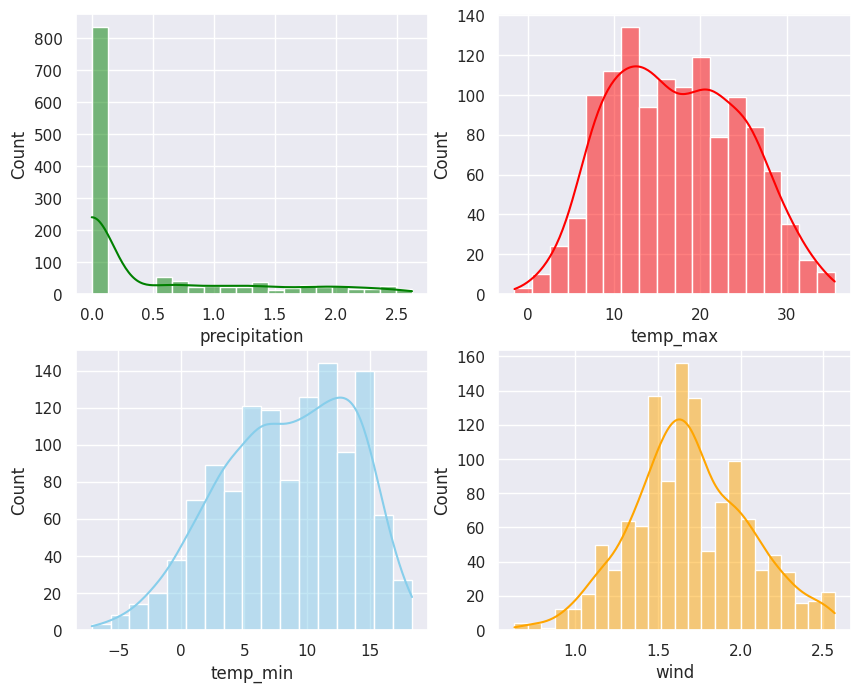

In [21]:
# Đặt kiểu hiển thị biểu đồ là "darkgrid" (nền tối có lưới)
sns.set(style="darkgrid")

# Tạo lưới biểu đồ 2x2 với kích thước được chỉ định
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Lặp qua từng cột và chỉ số tương ứng trong DataFrame
for i, column in enumerate(["precipitation", "temp_max", "temp_min", "wind"]):

    # Tạo biểu đồ histogram cho cột hiện tại, có thêm đường mật độ KDE (ước lượng mật độ xác suất)
    # Gán trục hiện tại vào vị trí thích hợp trong lưới biểu đồ
    # Đặt màu cho biểu đồ dựa trên vị trí của cột
    sns.histplot(data=df, x=column, kde=True, ax=axs[i//2, i%2], color=['green', 'red', 'skyblue', 'orange'][i])

In [22]:
df.head()

,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,0.000000,12.8,5.0,2.167948,drizzle,0
2,0.894427,11.7,7.2,1.516575,rain,2
4,1.140175,8.9,2.8,2.469818,rain,2
5,1.581139,4.4,2.2,1.483240,rain,2
6,0.000000,7.2,2.8,1.516575,rain,2


In [23]:
df.weather_encoded.unique()

array([0, 2, 4, 3, 1])

In [24]:
X = df.drop(["weather", "weather_encoded"], axis=1).values
y = df["weather_encoded"].values

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=32)

#**4.Xây dựng Mô hình**

##Softmax Regression

In [27]:
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(np.log(y_pred[range(m), y_true])) / m

def one_hot(y, num_classes):
    m = y.shape[0]
    result = np.zeros((m, num_classes))
    result[np.arange(m), y] = 1
    return result

def train_softmax_regression(X, y, num_classes, lr=0.1, epochs=1000):
    m, n = X.shape
    W = np.zeros((n, num_classes))
    b = np.zeros((1, num_classes))
    y_onehot = one_hot(y, num_classes)

    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        logits = X @ W + b
        probs = softmax(logits)
        loss = cross_entropy(y, probs)

        # Dự đoán nhãn hiện tại
        y_pred = np.argmax(probs, axis=1)
        acc = np.mean(y_pred == y)

        # Lưu lịch sử
        loss_history.append(loss)
        acc_history.append(acc)

        # Tính gradient
        dW = (1/m) * X.T @ (probs - y_onehot)
        db = (1/m) * np.sum(probs - y_onehot, axis=0, keepdims=True)

        # Cập nhật tham số
        W -= lr * dW
        b -= lr * db

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

    return W, b, loss_history, acc_history


def predict(X, W, b):
    logits = X @ W + b
    probs = softmax(logits)
    return np.argmax(probs, axis=1)

In [28]:
num_classes = len(np.unique(y))

W, b, loss_history, acc_history = train_softmax_regression(X_train, y_train, num_classes=num_classes, lr=0.1, epochs=500)
y_pred = predict(X_test, W, b)

Epoch 0: Loss = 1.6094, Accuracy = 0.0436
Epoch 100: Loss = 0.7042, Accuracy = 0.8022
Epoch 200: Loss = 0.6490, Accuracy = 0.8225
Epoch 300: Loss = 0.6260, Accuracy = 0.8245
Epoch 400: Loss = 0.6122, Accuracy = 0.8256
Epoch 499: Loss = 0.6026, Accuracy = 0.8256


In [29]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8380566801619433
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        16
           2       0.95      0.88      0.91        84
           3       0.00      0.00      0.00         4
           4       0.79      1.00      0.88       133

    accuracy                           0.84       247
   macro avg       0.35      0.38      0.36       247
weighted avg       0.75      0.84      0.78       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


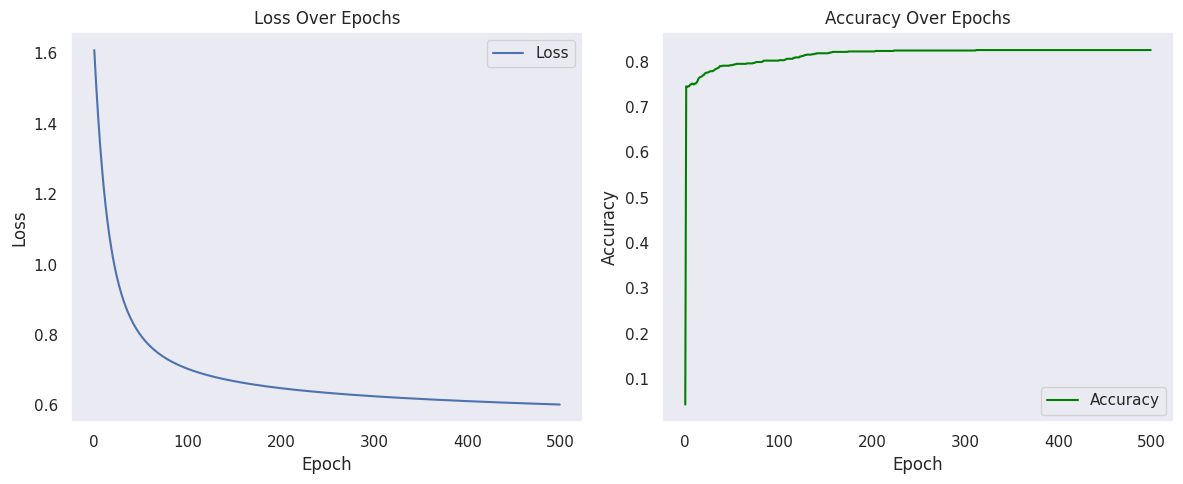

In [30]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='green')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

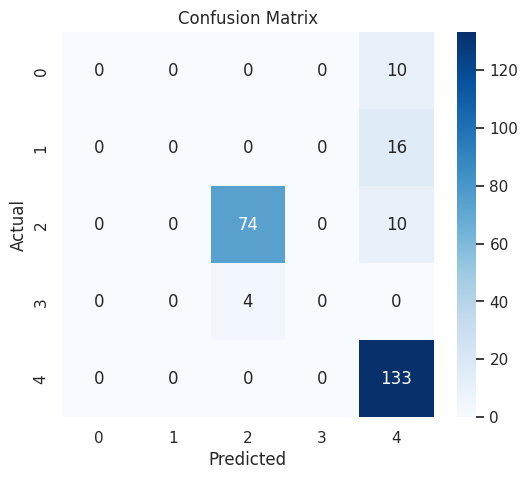

In [31]:
y_pred_test = predict(X_test, W, b)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
from sklearn.model_selection import KFold

def cross_validate_softmax(X, y, num_classes, lr, epochs, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    acc_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        W, b, _, _ = train_softmax_regression(X_train, y_train, num_classes, lr=lr, epochs=epochs)
        y_pred = predict(X_val, W, b)
        acc = accuracy_score(y_val, y_pred)
        acc_scores.append(acc)

    return np.mean(acc_scores)

# Lưới siêu tham số cần thử
learning_rates = [0.001, 0.01, 0.1, 1, 10]
epoch_list = [200, 500, 1000, 1200, 1500]
best_score = 0
best_params = {}
results = []  # Lưu lại tất cả các kết quả

for lr in learning_rates:
    for ep in epoch_list:
        print(f"Đang kiểm tra: lr = {lr}, epochs = {ep}")
        avg_acc = cross_validate_softmax(X_train, y_train, num_classes=num_classes, lr=lr, epochs=ep)
        print(f"    Trung bình accuracy (CV): {avg_acc:.4f}")
        results.append({
            "learning_rate": lr,
            "epochs": ep,
            "accuracy": avg_acc
        })

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = {'lr': lr, 'epochs': ep}

# Đưa vào DataFrame để dễ vẽ
results_df = pd.DataFrame(results)

print("\nSiêu tham số tốt nhất:", best_params)
print("Accuracy tốt nhất (CV):", best_score)

Đang kiểm tra: lr = 0.001, epochs = 200
Epoch 0: Loss = 1.6094, Accuracy = 0.0368
Epoch 100: Loss = 1.5602, Accuracy = 0.7513
Epoch 199: Loss = 1.5140, Accuracy = 0.7513
Epoch 0: Loss = 1.6094, Accuracy = 0.0456
Epoch 100: Loss = 1.5606, Accuracy = 0.7389
Epoch 199: Loss = 1.5147, Accuracy = 0.7389
Epoch 0: Loss = 1.6094, Accuracy = 0.0406
Epoch 100: Loss = 1.5603, Accuracy = 0.7414
Epoch 199: Loss = 1.5143, Accuracy = 0.7414
Epoch 0: Loss = 1.6094, Accuracy = 0.0482
Epoch 100: Loss = 1.5600, Accuracy = 0.7478
Epoch 199: Loss = 1.5136, Accuracy = 0.7465
Epoch 0: Loss = 1.6094, Accuracy = 0.0469
Epoch 100: Loss = 1.5604, Accuracy = 0.7516
Epoch 199: Loss = 1.5144, Accuracy = 0.7516
    Trung bình accuracy (CV): 0.7454
Đang kiểm tra: lr = 0.001, epochs = 500
Epoch 0: Loss = 1.6094, Accuracy = 0.0368
Epoch 100: Loss = 1.5602, Accuracy = 0.7513
Epoch 200: Loss = 1.5135, Accuracy = 0.7513
Epoch 300: Loss = 1.4694, Accuracy = 0.7525
Epoch 400: Loss = 1.4277, Accuracy = 0.7538
Epoch 499: Loss

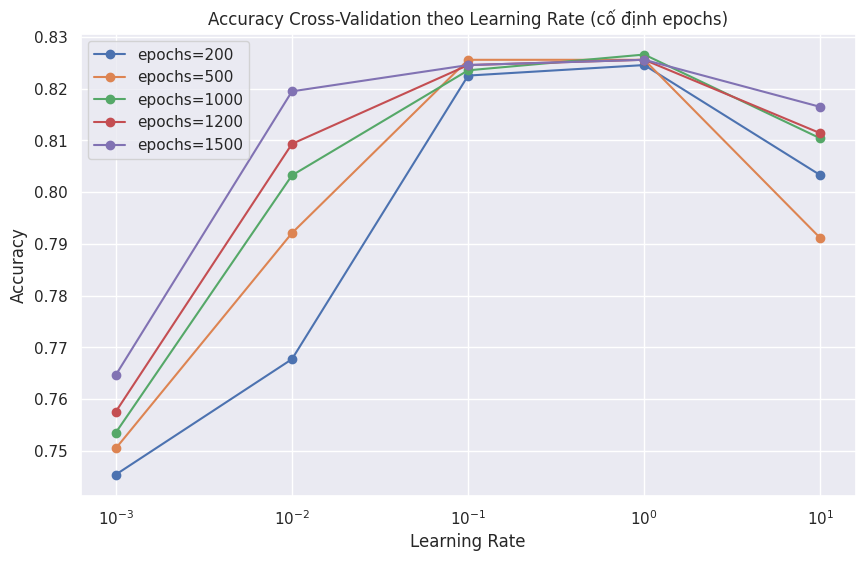

In [33]:
plt.figure(figsize=(10, 6))
for ep in epoch_list:
    subset = results_df[results_df["epochs"] == ep]
    plt.plot(subset["learning_rate"], subset["accuracy"], marker='o', label=f"epochs={ep}")

plt.title("Accuracy Cross-Validation theo Learning Rate (cố định epochs)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.xscale('log')  # Vì learning rate dạng log
plt.show()

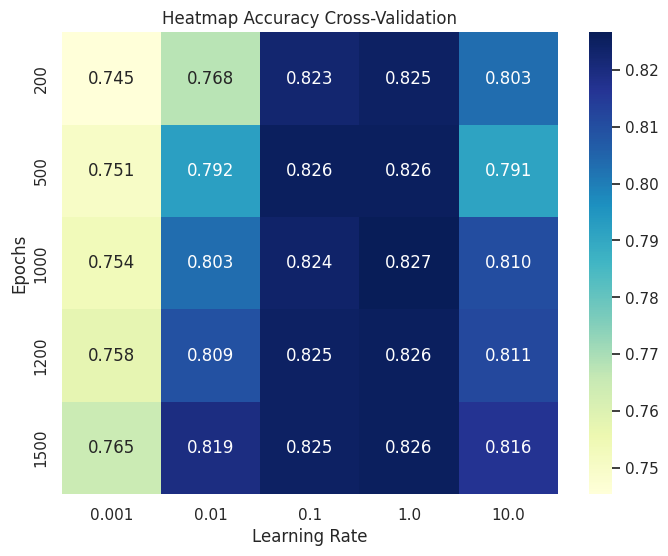

In [34]:
heatmap_data = results_df.pivot(index="epochs", columns="learning_rate", values="accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap Accuracy Cross-Validation")
plt.xlabel("Learning Rate")
plt.ylabel("Epochs")
plt.show()

In [35]:
W, b, loss_history, acc_history = train_softmax_regression(
    X_train, y_train,
    num_classes=num_classes,
    lr=best_params['lr'],
    epochs=best_params['epochs']
)

Epoch 0: Loss = 1.6094, Accuracy = 0.0436
Epoch 100: Loss = 0.5759, Accuracy = 0.8266
Epoch 200: Loss = 0.5562, Accuracy = 0.8256
Epoch 300: Loss = 0.5479, Accuracy = 0.8256
Epoch 400: Loss = 0.5433, Accuracy = 0.8266
Epoch 500: Loss = 0.5404, Accuracy = 0.8266
Epoch 600: Loss = 0.5384, Accuracy = 0.8266
Epoch 700: Loss = 0.5370, Accuracy = 0.8276
Epoch 800: Loss = 0.5359, Accuracy = 0.8276
Epoch 900: Loss = 0.5350, Accuracy = 0.8276
Epoch 999: Loss = 0.5343, Accuracy = 0.8276


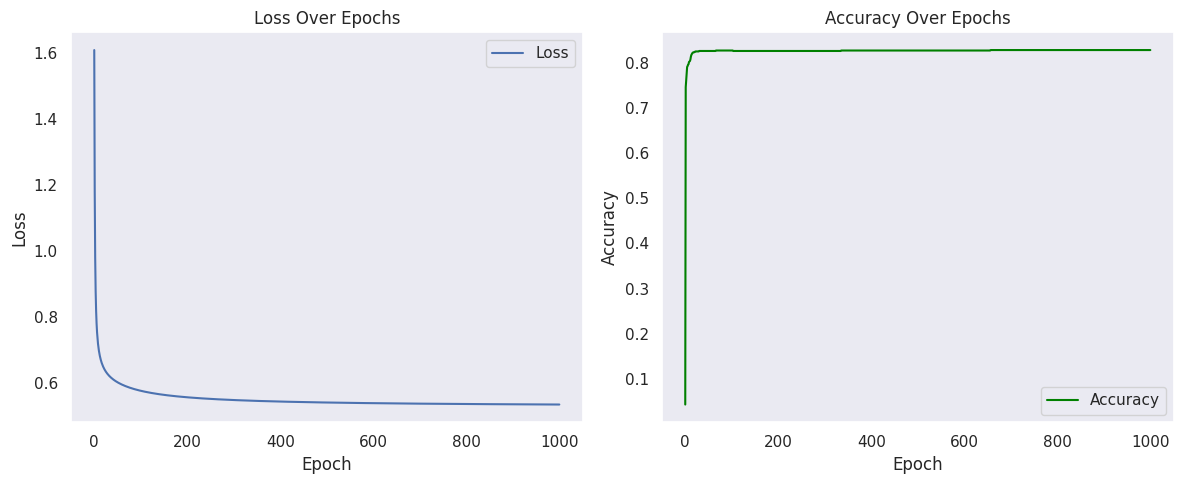

In [36]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='green')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

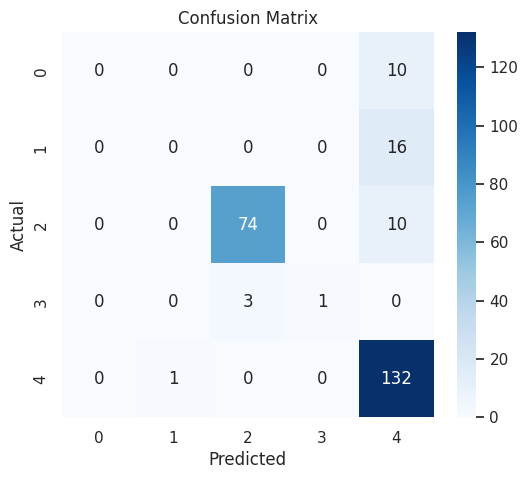

In [37]:
y_pred_test = predict(X_test, W, b)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy: 0.8380566801619433
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        16
           2       0.96      0.88      0.92        84
           3       1.00      0.25      0.40         4
           4       0.79      0.99      0.88       133

    accuracy                           0.84       247
   macro avg       0.55      0.42      0.44       247
weighted avg       0.77      0.84      0.79       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##K Nearest Neighbor (KNN)

In [39]:
from collections import Counter

# Hàm tính khoảng cách Euclidean
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Hàm KNN dự đoán nhãn
def predict_knn(X_train, y_train, X_test, k=5):
    y_pred = []

    for test_point in X_test:
        distances = []

        # Tính khoảng cách tới tất cả điểm trong X_train
        for i in range(len(X_train)):
            dist = euclidean_distance(test_point, X_train[i])
            distances.append((dist, y_train[i]))

        # Lấy k điểm gần nhất
        k_neighbors = sorted(distances, key=lambda x: x[0])[:k]

        # Lấy nhãn phổ biến nhất (majority vote)
        labels = [label for _, label in k_neighbors]
        most_common = Counter(labels).most_common(1)[0][0]

        y_pred.append(most_common)

    return np.array(y_pred)

In [40]:
# Dự đoán nhãn cho tập test
y_pred_knn = predict_knn(X_train, y_train, X_test, k=5)

In [41]:
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy KNN: 0.8218623481781376
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.18      0.12      0.15        16
           2       0.95      0.88      0.91        84
           3       1.00      0.25      0.40         4
           4       0.80      0.95      0.87       133

    accuracy                           0.82       247
   macro avg       0.59      0.44      0.47       247
weighted avg       0.78      0.82      0.79       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


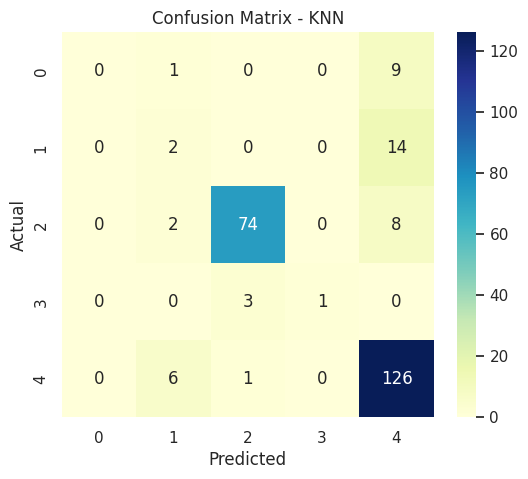

In [42]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
def cross_validate_knn(X, y, k_neighbors, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    acc_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        y_pred_fold = predict_knn(X_train_fold, y_train_fold, X_val_fold, k=k_neighbors)
        acc = accuracy_score(y_val_fold, y_pred_fold)
        acc_scores.append(acc)

    return np.mean(acc_scores)

In [44]:
# Các giá trị k cần thử
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracy_list = []
best_k = None
best_score = 0

for k in k_values:
    print(f"Đang thử với k = {k}")
    avg_acc = cross_validate_knn(X_train, y_train, k_neighbors=k)
    accuracy_list.append(avg_acc)
    print(f"    Trung bình accuracy (CV): {avg_acc:.4f}")

    if avg_acc > best_score:
        best_score = avg_acc
        best_k = k

print("\nk tốt nhất:", best_k)
print("Accuracy CV cao nhất:", best_score)

Đang thử với k = 1
    Trung bình accuracy (CV): 0.7393
Đang thử với k = 3
    Trung bình accuracy (CV): 0.7911
Đang thử với k = 5
    Trung bình accuracy (CV): 0.7961
Đang thử với k = 7
    Trung bình accuracy (CV): 0.7982
Đang thử với k = 9
    Trung bình accuracy (CV): 0.8012
Đang thử với k = 11
    Trung bình accuracy (CV): 0.8093
Đang thử với k = 13
    Trung bình accuracy (CV): 0.8103
Đang thử với k = 15
    Trung bình accuracy (CV): 0.8083

k tốt nhất: 13
Accuracy CV cao nhất: 0.8103317438342819


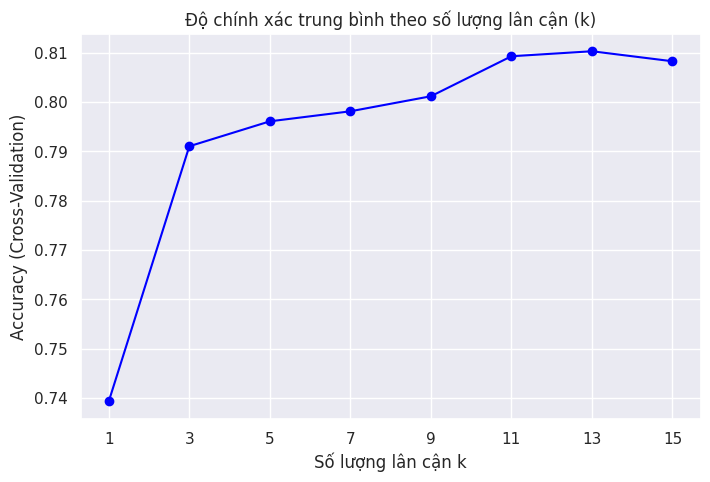

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_list, marker='o', linestyle='-', color='blue')
plt.title("Độ chính xác trung bình theo số lượng lân cận (k)")
plt.xlabel("Số lượng lân cận k")
plt.ylabel("Accuracy (Cross-Validation)")
plt.grid(True)
plt.xticks(k_values)
plt.show()

In [46]:
# Dự đoán trên tập test với k tốt nhất
y_pred_knn = predict_knn(X_train, y_train, X_test, k=best_k)

In [47]:
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy KNN: 0.8380566801619433
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      0.06      0.11        16
           2       0.95      0.88      0.91        84
           3       0.00      0.00      0.00         4
           4       0.79      0.99      0.88       133

    accuracy                           0.84       247
   macro avg       0.45      0.39      0.38       247
weighted avg       0.78      0.84      0.79       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


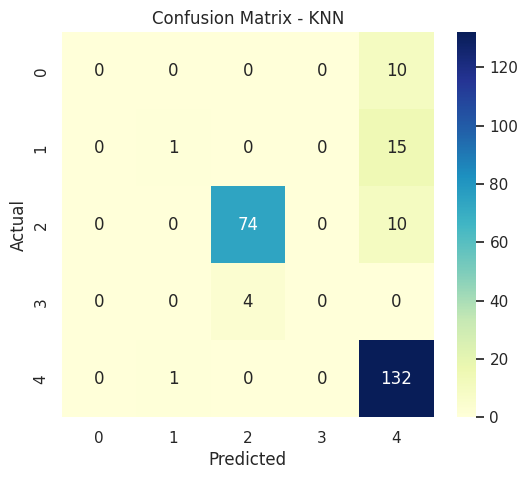

In [48]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##Decision Tree

In [49]:
def entropy(y):
    labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # +1e-9 tránh log(0)

def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold

    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None

    current_entropy = entropy(y)

    n_samples, n_features = X.shape

    for feature_idx in range(n_features):
        thresholds = np.unique(X[:, feature_idx])

        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_idx, threshold)

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            p_left = len(y_left) / len(y)
            p_right = 1 - p_left

            gain = current_entropy - (p_left * entropy(y_left) + p_right * entropy(y_right))

            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold

In [50]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # dùng khi node là lá

def build_tree(X, y, depth=0, max_depth=5, min_samples_split=2):
    # Dừng nếu đạt độ sâu max hoặc số lượng mẫu quá ít hoặc nhãn đồng nhất
    if len(set(y)) == 1 or len(y) < min_samples_split or depth >= max_depth:
        most_common = Counter(y).most_common(1)[0][0]
        return DecisionNode(value=most_common)

    feature, threshold = best_split(X, y)
    if feature is None:
        most_common = Counter(y).most_common(1)[0][0]
        return DecisionNode(value=most_common)

    X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)
    left_subtree = build_tree(X_left, y_left, depth + 1, max_depth, min_samples_split)
    right_subtree = build_tree(X_right, y_right, depth + 1, max_depth, min_samples_split)

    return DecisionNode(feature, threshold, left_subtree, right_subtree)

In [51]:
def predict_sample(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

def predict_tree(tree, X):
    return np.array([predict_sample(tree, x) for x in X])


In [52]:
# Huấn luyện
tree = build_tree(X_train, y_train, max_depth=5)

In [53]:
# Dự đoán
y_pred = predict_tree(tree, X_test)

In [54]:
# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8502024291497976
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        16
           2       0.99      0.88      0.93        84
           3       1.00      0.75      0.86         4
           4       0.79      1.00      0.88       133

    accuracy                           0.85       247
   macro avg       0.55      0.53      0.53       247
weighted avg       0.78      0.85      0.80       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


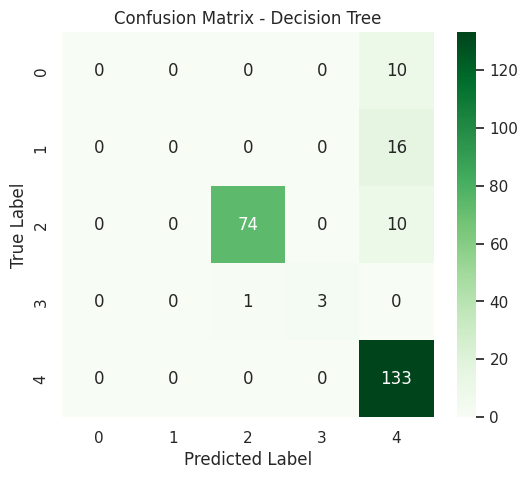

In [55]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [58]:
def cross_validate_tree(X, y, max_depth, min_samples_split, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    acc_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        tree = build_tree(X_train, y_train,
                          max_depth=max_depth,
                          min_samples_split=min_samples_split)
        y_pred = predict_tree(tree, X_val)
        acc = accuracy_score(y_val, y_pred)
        acc_scores.append(acc)

    return np.mean(acc_scores)

In [59]:
depth_list = [3, 5, 7, 9, 11]
min_split_list = [2, 5, 7, 10]

best_score = 0
best_params = {}

results = []

for depth in depth_list:
    for min_split in min_split_list:
        print(f"Đang thử: max_depth = {depth}, min_samples_split = {min_split}")
        avg_acc = cross_validate_tree(X_train, y_train, max_depth=depth, min_samples_split=min_split)
        results.append((depth, min_split, avg_acc))
        print(f"    Accuracy (CV): {avg_acc:.4f}")

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = {'max_depth': depth, 'min_samples_split': min_split}

print("\nSiêu tham số tốt nhất:", best_params)
print("Accuracy cao nhất (CV):", best_score)

Đang thử: max_depth = 3, min_samples_split = 2
    Accuracy (CV): 0.8276
Đang thử: max_depth = 3, min_samples_split = 5
    Accuracy (CV): 0.8276
Đang thử: max_depth = 3, min_samples_split = 7
    Accuracy (CV): 0.8276
Đang thử: max_depth = 3, min_samples_split = 10
    Accuracy (CV): 0.8276
Đang thử: max_depth = 5, min_samples_split = 2
    Accuracy (CV): 0.8266
Đang thử: max_depth = 5, min_samples_split = 5
    Accuracy (CV): 0.8276
Đang thử: max_depth = 5, min_samples_split = 7
    Accuracy (CV): 0.8276
Đang thử: max_depth = 5, min_samples_split = 10
    Accuracy (CV): 0.8276
Đang thử: max_depth = 7, min_samples_split = 2
    Accuracy (CV): 0.8043
Đang thử: max_depth = 7, min_samples_split = 5
    Accuracy (CV): 0.8083
Đang thử: max_depth = 7, min_samples_split = 7
    Accuracy (CV): 0.8093
Đang thử: max_depth = 7, min_samples_split = 10
    Accuracy (CV): 0.8093
Đang thử: max_depth = 9, min_samples_split = 2
    Accuracy (CV): 0.7829
Đang thử: max_depth = 9, min_samples_split = 5
 

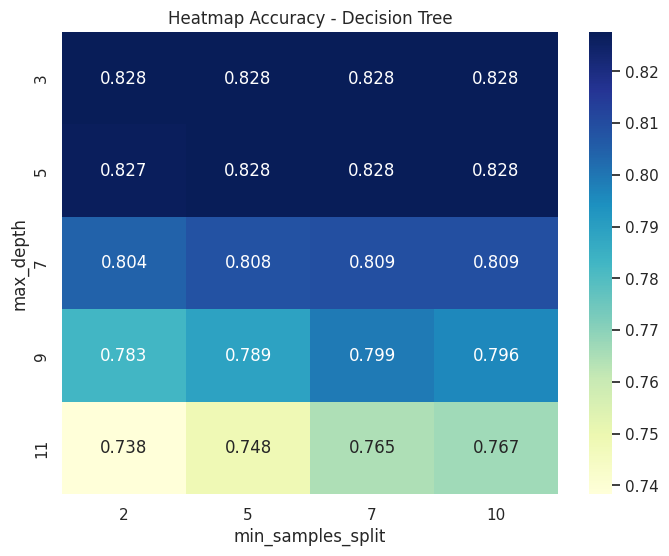

In [60]:
# Chuyển kết quả sang DataFrame để vẽ
df_results = pd.DataFrame(results, columns=["max_depth", "min_samples_split", "accuracy"])
heatmap_data = df_results.pivot(index="max_depth", columns="min_samples_split", values="accuracy")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap Accuracy - Decision Tree")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()

In [61]:
tree = build_tree(X_train, y_train, max_depth=depth, min_samples_split=min_split)
y_pred_tree = predict_tree(tree, X_test)

In [62]:
# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.36      0.25      0.30        16
           2       0.97      0.88      0.93        84
           3       1.00      0.75      0.86         4
           4       0.82      0.96      0.88       133

    accuracy                           0.85       247
   macro avg       0.63      0.57      0.59       247
weighted avg       0.81      0.85      0.82       247



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


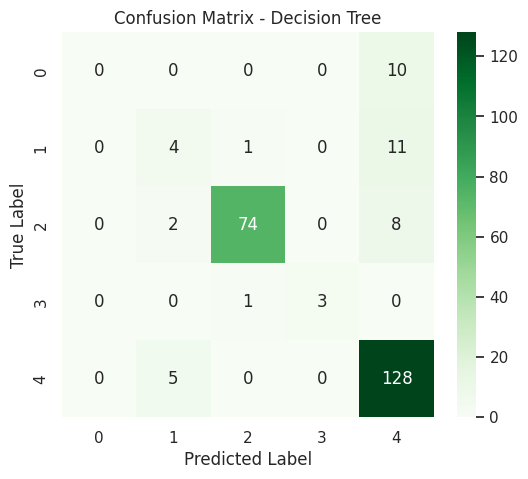

In [63]:
cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#**5.SO SÁNH BA MÔ HÌNH**

##Độ chính xác của từng mô hình

In [65]:
acc_softmax = accuracy_score(y_test, y_pred_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_tree = accuracy_score(y_test, y_pred_tree)

print("Accuracy các mô hình:")
print(f"Softmax Regression:  {acc_softmax:.4f}")
print(f"KNN:                 {acc_knn:.4f}")
print(f"Decision Tree:       {acc_tree:.4f}")

Accuracy các mô hình:
Softmax Regression:  0.8381
KNN:                 0.8381
Decision Tree:       0.8462


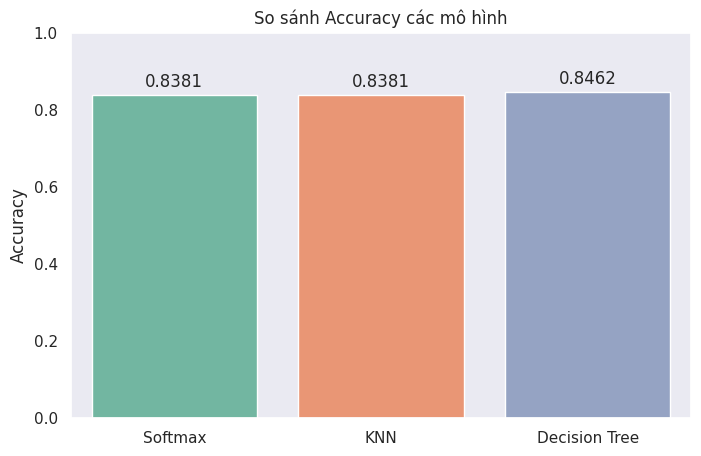

In [66]:
model_names = ['Softmax', 'KNN', 'Decision Tree']
accuracies = [acc_softmax, acc_knn, acc_tree]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='Set2')
plt.title("So sánh Accuracy các mô hình")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center')
plt.show()

##Classification Report

In [67]:
print("Classification Report - Softmax:")
print(classification_report(y_test, y_pred_test))

print("Classification Report - KNN:")
print(classification_report(y_test, y_pred_knn))

print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred_tree))

Classification Report - Softmax:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        16
           2       0.96      0.88      0.92        84
           3       1.00      0.25      0.40         4
           4       0.79      0.99      0.88       133

    accuracy                           0.84       247
   macro avg       0.55      0.42      0.44       247
weighted avg       0.77      0.84      0.79       247

Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      0.06      0.11        16
           2       0.95      0.88      0.91        84
           3       0.00      0.00      0.00         4
           4       0.79      0.99      0.88       133

    accuracy                           0.84       247
   macro avg       0.45      0.39      0.38       247
weighted avg   

##Ma trận nhầm lẫn

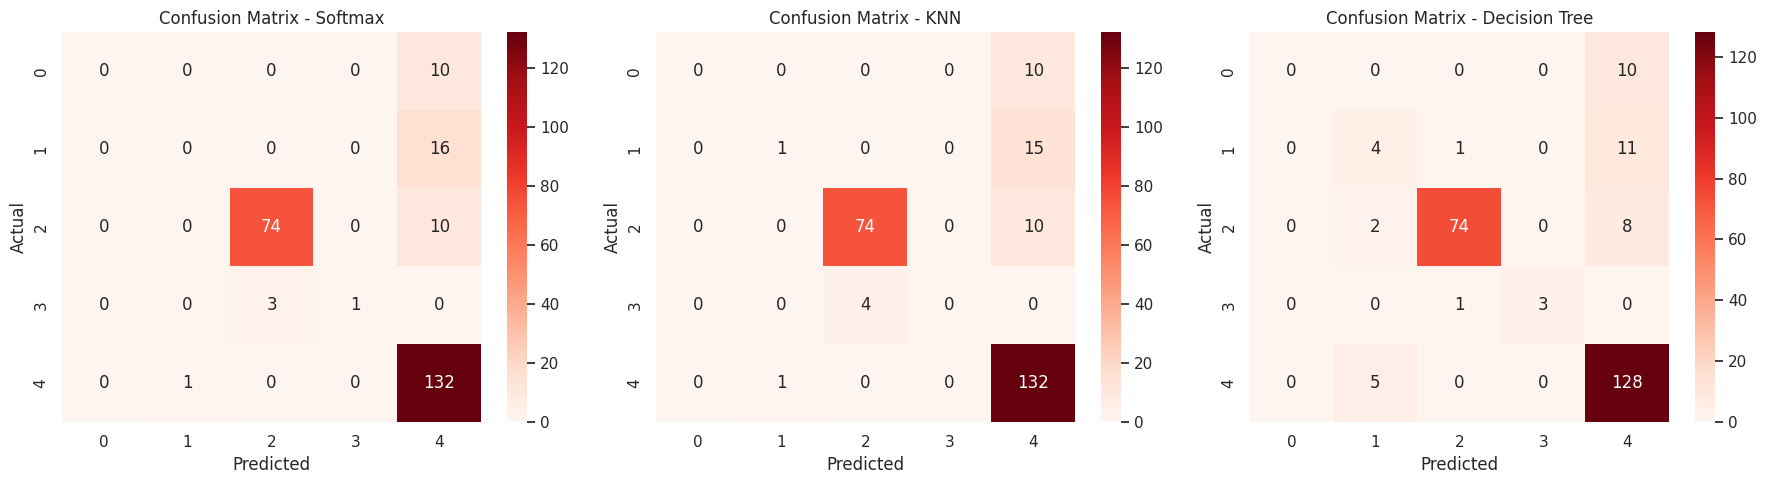

In [68]:
models = {
    "Softmax": y_pred_test,
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_tree
}

plt.figure(figsize=(18, 5))
for i, (name, y_pred) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

#**6.Kiểm tra**

In [69]:
# Dự đoán trên tập test
y_pred_tree = predict_tree(tree, X_test)

# In từng mẫu
for i in range(20):
    pred = y_pred_tree[i]
    actual = y_test[i]

    pred_label = le.inverse_transform([pred])[0]
    actual_label = le.inverse_transform([actual])[0]

    print("------------------")
    print("Dự đoán :", pred_label)
    print("Thực tế  :", actual_label)

------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : sun
Thực tế  : fog
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : sun
Thực tế  : fog
------------------
Dự đoán : sun
Thực tế  : drizzle
------------------
Dự đoán : rain
Thực tế  : rain
------------------
Dự đoán : sun
Thực tế  : sun
------------------
Dự đoán : sun
Thực tế  : sun


In [70]:
#Kiểm tra với dữ liệu mới
# Một mẫu input: [precipitation, temp_max, temp_min, wind]
sample = np.array([[0.2, 21.0, 13.0, 2.5]])
sample_scaled = scaler.transform(sample)
# Dự đoán nhãn (dạng số)
predicted_label = predict_tree(tree, sample_scaled)[0]
# Đổi từ số → nhãn chữ
predicted_weather = le.inverse_transform([predicted_label])[0]

print("Dự báo thời tiết cho mẫu input:")
print(predicted_weather)

Dự báo thời tiết cho mẫu input:
rain


In [71]:
#Kiểm tra với dữ liệu mới
# Một mẫu input: [precipitation, temp_max, temp_min, wind]
sample = np.array([[0.5, 6.0, 0.0, 3]])
sample_scaled = scaler.transform(sample)
# Dự đoán nhãn (dạng số)
predicted_label = predict_tree(tree, sample_scaled)[0]
# Đổi từ số → nhãn chữ
predicted_weather = le.inverse_transform([predicted_label])[0]

print("Dự báo thời tiết cho mẫu input:")
print(predicted_weather)

Dự báo thời tiết cho mẫu input:
snow


In [72]:
#Kiểm tra với dữ liệu mới
# Một mẫu input: [precipitation, temp_max, temp_min, wind]
sample = np.array([[0.0,39.6,38.0,0.02]])
sample_scaled = scaler.transform(sample)
# Dự đoán nhãn (dạng số)
predicted_label = predict_tree(tree, sample_scaled)[0]
# Đổi từ số → nhãn chữ
predicted_weather = le.inverse_transform([predicted_label])[0]

print("Dự báo thời tiết cho mẫu input:")
print(predicted_weather)

Dự báo thời tiết cho mẫu input:
sun
